In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Setup logging with some hacks to work in the notebook.
import logging
import sys

logger = logging.getLogger()
# logger.handlers[0].stream = sys.stdout
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import keras.backend as K
from keras.metrics import binary_crossentropy
from math import sqrt
from skimage.transform import resize

import sys; sys.path.append('../')
from src.models.unet_jocic import UNet
from src.utils.runtime import gpu_selection
from src.utils.data import random_transforms
from src.utils.model import dice_coef, jaccard_coef

logger.info('Done')

Using TensorFlow backend.
Done


In [2]:
# Load data.
model = UNet()
model.config['data_path'] = '../data'
model.load_data()
logger.info('Done')

Reading images from ../data.
Combining images and masks into montages.
Combining validation images and masks into montages
Done


In [ ]:
# Plot image and mask montages.
fig,_ = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

fig.axes[0].set_title('Images Montage Train')
fig.axes[0].imshow(model.imgs_montage_trn, cmap='gray')
fig.axes[1].set_title('Masks Montage Train')
fig.axes[1].imshow(model.msks_montage_trn, cmap='gray')
fig.axes[2].set_title('Images Montage Vaidate')
fig.axes[2].imshow(model.imgs_montage_val, cmap='gray')
fig.axes[3].set_title('Masks Montage Vaidate')
fig.axes[3].imshow(model.msks_montage_val, cmap='gray')

plt.show()

In [3]:
# Plot random transformations.
# np.random.seed(model.config['seed'])
data_gen = model.batch_gen(imgs=model.imgs_montage_trn, msks=model.msks_montage_trn, infinite=True, 
                           re_seed=True, batch_size=1, transform=True)

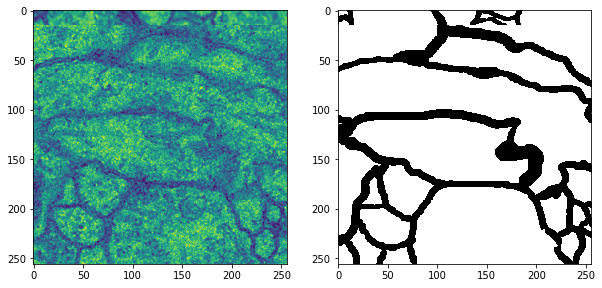

In [4]:
img_batch, msk_batch = next(data_gen)

img = img_batch[0].reshape(256,256)
msk = msk_batch[0].reshape(256,256)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(msk, cmap='gray')

In [5]:
np.unique(msk_batch)

array([0., 1.])

In [ ]:
# Plot random transformations.
np.random.seed(model.config['seed'])
data_gen = model.batch_gen(imgs=model.imgs_montage_trn, msks=model.msks_montage_trn, batch_size=1)
img_batch, msk_batch = next(data_gen)
img = img_batch[0].reshape(256,256)
msk = msk_batch[0].reshape(256,256)

# plt.imshow(img)
# plt.show()

fig, _ = plt.subplots(nrows=2, ncols=2, figsize=(8,5))

for ax in fig.axes:
    [img_t, msk_t] = random_transforms([img, msk], nb_min=1, nb_max=1)
    ax.axis('off')
    ax.imshow(np.hstack([img_t,msk_t]))
    msk_diff = abs(np.sum(msk) - np.sum(msk_t))
    ax.set_title('%.2lf' % (msk_diff))
    
plt.show()

In [12]:
# Load network.
gpu_selection(visible_devices="1")
model.compile()
model.net.load_weights('../checkpoints/unet_jocic_256_val_loss.net')
logger.info('Done')

Done


In [ ]:
# Plot predictions.
def metric_wrapper(yt, yp, metric):
    return K.get_value(metric(K.variable(yt), K.variable(yp)))

data_gen = model.batch_gen(imgs=model.imgs_montage_val, msks=model.msks_montage_val, batch_size=10)
img_batch, msk_batch = next(data_gen)

prd_batch = model.net.predict(img_batch)

for img, msk, prd in zip(img_batch, msk_batch, prd_batch):
    r = c = int(sqrt(img.size))  # 256
    b = np.mean(metric_wrapper(msk, prd, binary_crossentropy))
    d = metric_wrapper(msk, prd, dice_coef)
    j = metric_wrapper(msk, prd, jaccard_coef)
    
    fig,_ = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
    fig.axes[0].set_title('Image')
    fig.axes[0].imshow(img.reshape(r,c), cmap='gray')
    fig.axes[1].set_title('True Mask')
    fig.axes[1].imshow(msk.reshape(r,c), cmap='gray')
    fig.axes[2].set_title('Pred Mask')
    fig.axes[2].imshow(prd.reshape(r,c), cmap='gray')
    fig.axes[3].set_title('True Classes')
    fig.axes[3].hist(msk.reshape(msk.size), label='T', alpha=0.4, bins=2)
    fig.axes[3].hist(prd.reshape(prd.size) + 2, label='P', alpha=0.4, bins=2)
    fig.axes[3].set_xticklabels([0,0,1,0,1],rotation='vertical')
    fig.axes[3].legend()
    fig.suptitle('loss = %.3lf, dc = %.3lf, j = %.3lf' % (b,d,j))    
    plt.show()

In [ ]:
# Plot submission images and predictions.
imgs_test = tiff.imread('../data/test-volume.tif')
msks_test = tiff.imread('../checkpoints/unet_jocic_256.submission.tif')

for img, msk in zip(imgs_test, msks_test):
    fig, _ = plt.subplots(nrows=1, ncols=2)
    fig.axes[0].imshow(img, cmap='gray')
    fig.axes[0].set_title('Test Image')
    fig.axes[1].imshow(msk, cmap='gray')
    fig.axes[1].set_title('Prediction')
    plt.show()